# Uncertainty ellipsoid

In [1]:
using Revise

In [2]:
using LowRankVortex

[ Info: Precompiling LowRankVortex [fdf095b8-6f21-420b-9d49-8e692abb03d1]


In [3]:
using PotentialFlow

In [4]:
using CairoMakie
#using Plots
#pyplot()

In [5]:
using LaTeXStrings

In [6]:
using Distributions
using Random
using LinearAlgebra
using GaussianMixtures
using Statistics

### Truth

In [204]:
LowRankVortex.get_config_and_state(Nv;kwargs...) = get_config_and_state(default_vortex(Nv)...;kwargs...)

default_vortex(Nv) = _default_vortex(Val(Nv))

function _default_vortex(::Val{1})
    zv = [0.5+1.0im]
    Γv = [1.0] 
    return zv, Γv
end

function _default_vortex(::Val{2})
    zv = [-1.0+0.75im,0.75+0.5im]  # [-1.0+0.75im,0.75+0.5im]
    Γv = [1.2,0.4] #[1.2,0.4] #[1.2,-1.0] 
    return zv, Γv
end

function _default_vortex(::Val{3})
    zv = [-0.75+0.75im,0.25+0.5im,0.75+0.75im]
    Γv = [1.0,-1.2,1.4]
    return zv, Γv
end

_default_vortex (generic function with 3 methods)

### Set some plotting themes

In [10]:
xytheme = Theme(
        Axis = (aspect=DataAspect(),xlabel=L"x",ylabel=L"y"),
        palette = (color = Makie.wong_colors(),),
        Lines = (cycle = [:color],),
        Scatter = (cycle = [:color],)
    );

sensortheme = Theme(
    Axis = (xlabel="Sensor no.",ylabel=L"p-p_\infty")
);

#### Set up the observer for the truth data

In [184]:
Nv_true = 3
Nsens = 9

ϵmeas_data = [2.5e-4,3.75e-4,5e-4,6.25e-4,8e-4,1e-3,1.5e-3,2e-3,3e-3,4e-3];
ϵmeas = ϵmeas_data[3] #5e-4 #1e-3

config_true, x_true = get_config_and_state(Nv_true)
obs_true, ystar, H, Σϵ, Σx = get_truth_data(Nsens,ϵmeas,x_true,config_true);

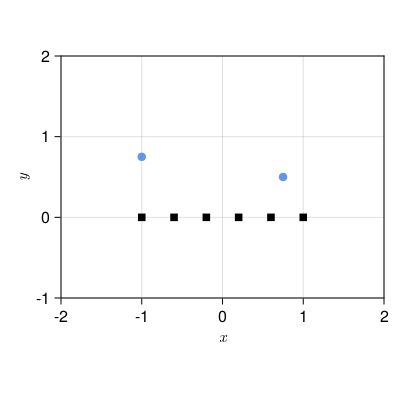

In [57]:
with_theme(xytheme) do
    f = Figure(;resolution = (400, 400))
    ax = f[1,1] = Axis(f;limits=(-2,2,-1,2))
    show_singularities!(ax,x_true,obs_true)
    plot_sensors!(ax,obs_true)
    f
end

### Evaluate the true sensor data and add noise

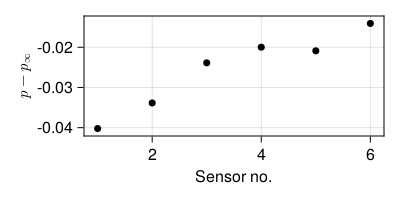

In [58]:
with_theme(sensortheme) do
    f = Figure(;resolution = (400, 200))
    ax = f[1,1] = Axis(f)
    plot_sensor_data!(ax,ystar,obs_true;sensor_noise=ϵmeas*ones(length(ystar)))
    f
end

In [59]:
xid, yid, Γid = get_singularity_ids(obs_true.config)

([1, 4], [2, 5], [3, 6])

### Get the Jacobian

In [18]:
#Σx = inv(H'*inv(Σϵ)*H)

In [192]:
Nsens = 12
zv, Γv = default_vortex(3)
#zv .+= 0.42*[1,-1]
#Γv = [1.2,-1.0]
config_true, x_true = get_config_and_state(zv,Γv)
obs_true, ystar, H, Σϵ, Σx = get_truth_data(Nsens,ϵmeas,x_true,config_true)
F = eigen(Σx);

In [194]:
F.values

9-element Vector{Float64}:
 3.109532367599255e-7
 2.5637007096949127e-6
 1.0239761114417912e-5
 2.3155904049097276e-5
 0.00013839131056503086
 0.0013695268459520415
 0.014181135753052887
 0.07286841238031252
 3.2724891271873005

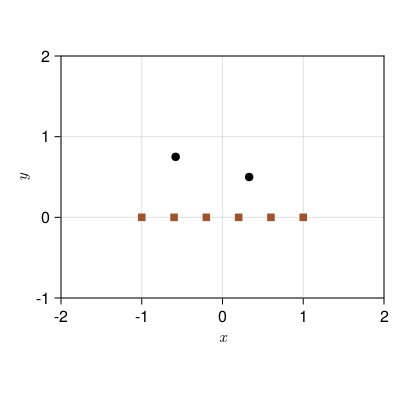

In [63]:
with_theme(xytheme) do
    f = Figure(;resolution = (400, 400))
    ax = f[1,1] = Axis(f;limits=(-2,2,-1,2))
    show_singularities!(ax,x_true,obs_true,color=:black)
    plot_sensors!(ax,obs_true,color=:sienna)
    f
end

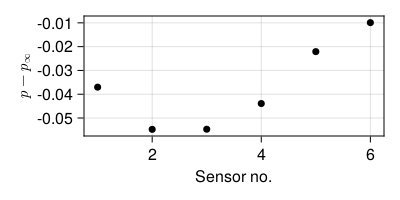

In [64]:
with_theme(sensortheme) do
    f = Figure(;resolution = (400, 200))
    ax = f[1,1] = Axis(f)
    plot_sensor_data!(ax,ystar,obs_true;sensor_noise=ϵmeas*ones(length(ystar)))
    f
end

In [205]:
Nsenslist = 9:15
dzvlist = -1.0:0.005:0.875-0.005
#zv, Γv = default_vortex(2)
#zv .+= 0.75*[1,-1]
#Γv = [1.2,-1.0]
#Γv = [1.2,0.4]
Flist = Eigen[]
xseplist = Float64[]
for Nsens in Nsenslist
    #for dzv in dzvlist
        zv, Γv = default_vortex(3)
        #zv .+= dzv*[1,-1]
        #Γv = [1.2,-1.0]
        #Γv = [1.2,0.4]
        config_true, x_true = get_config_and_state(zv,Γv)
        obs_true, ystar, H, Σϵ, Σx = get_truth_data(Nsens,ϵmeas,x_true,config_true)
        #F = rank(Σx) == state_length(config_true) ? eigen(inv(Σx)) : eigen(Σx)
        F = eigen(Σx)
        push!(Flist,deepcopy(F))
        push!(xseplist,real(zv[2]-zv[1]))
    #end
end

In [15]:
Σx[[xid[1],xid[2]],[xid[1],xid[2]]]

2×2 Matrix{Float64}:
  0.00186177   -0.000915458
 -0.000915458   0.00115836

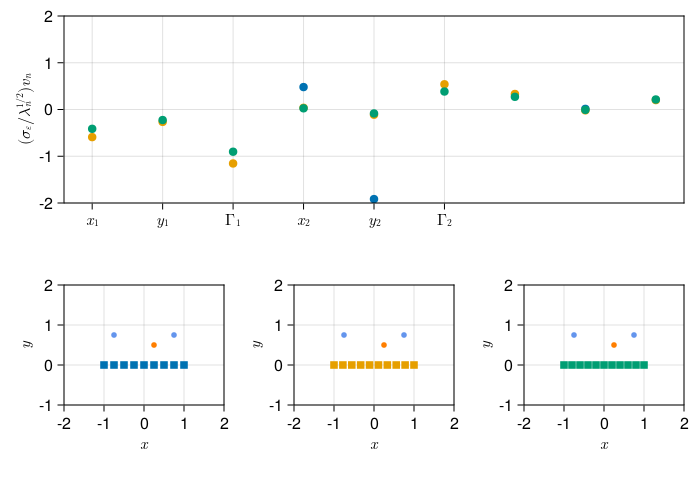

In [208]:
f = Figure(;resolution=(700,500))

ga = f[1,1] = GridLayout()
gb = f[2,1] = GridLayout()
gb1 = gb[1,1] = GridLayout()
gb2 = gb[1,2] = GridLayout()
gb3 = gb[1,3] = GridLayout()

select = [1,2,3]

axleft = Axis(ga[1,1];xticks=(1:6,[L"x_1",L"y_1",L"\Gamma_1",L"x_2",L"y_2",L"\Gamma_2"]),ylabel=L"(\sigma_\epsilon/\lambda_n^{1/2})v_n")
for j in 1:3
    selj = select[j]
    scatter!(axleft,sqrt(Flist[selj].values[end])*Flist[selj].vectors[:,end],label=L"d=%$(Nsenslist[selj])")
end
ylims!(axleft,(-2,2))
#axislegend(axleft,position=:rb)
with_theme(xytheme) do
    axright = [Axis(gb[1,1];limits=(-2,2,-1,2)),Axis(gb[1,2];limits=(-2,2,-1,2)),Axis(gb[1,3];limits=(-2,2,-1,2))]
    for j in 1:3
        selj = select[j]
        ystar, H, F, x_true, Σϵ, obs_true = get_observations_and_jacobian(zv,Γv,Nsenslist[selj],ϵmeas)
        show_singularities!(axright[j],x_true,obs_true,markersize=8)
        plot_sensors!(axright[j],obs_true,color=Makie.wong_colors()[j])
    end
end
#save("maxvariance-2vortex-varyd-G1p-G2p-case4.svg",f)
f

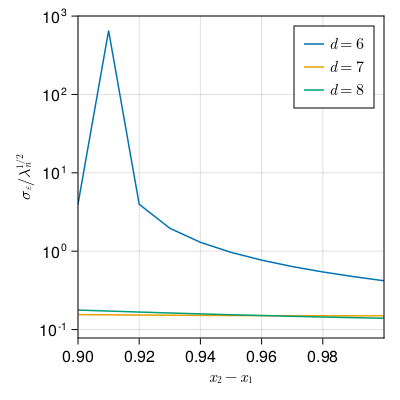

In [182]:
f = Figure(;resolution=(400,400))

ax = f[1,1] = Axis(f;yscale=log10,xlabel=L"x_2 - x_1",ylabel=L"\sigma_\epsilon/\lambda_n^{1/2}")
λrootmax6 = [sqrt(Flist6[j].values[end]) for j in 1:length(Flist6)]
λrootmax7 = [sqrt(Flist7[j].values[end]) for j in 1:length(Flist7)]
λrootmax8 = [sqrt(Flist8[j].values[end]) for j in 1:length(Flist8)]


#axleft = Axis(ga[1,1];xticks=(1:6,[L"x_1",L"y_1",L"\Gamma_1",L"x_2",L"y_2",L"\Gamma_2"]),ylabel=L"(\sigma_\epsilon/\lambda_n^{1/2})v_n")
lines!(ax,xseplist,λrootmax6,label=L"d=6")
lines!(ax,xseplist,λrootmax7,label=L"d=7")
lines!(ax,xseplist,λrootmax8,label=L"d=8")

axislegend(ax,position=:rt)
#xlims!(ax,(0,3.5))
xlims!(ax,(0.9,1.0))


#save("maxcovar-2vortex-G1p-G2p.svg",f)

f

In [91]:
diff(zv + dzvlist[end]*[1,-1])

1-element Vector{ComplexF64}:
 0.0 - 0.25im

In [183]:
val, idx = findmax(λrootmax6)
dzvlist[idx]
zv, Γv = default_vortex(2)
zv .+= dzvlist[xseplist.≈0.91].*[1,-1]

2-element Vector{ComplexF64}:
 -0.5800000000000001 + 0.75im
                0.33 + 0.5im

1-element Vector{Int64}:
 285

In [ ]:
find()
zv, Γv = default_vortex(2)
zv .+= dzvlist[idx]*[1,-1]

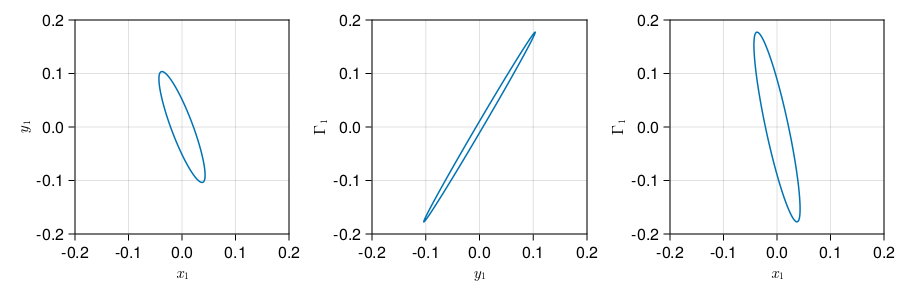

In [88]:
f = Figure(;resolution=(900,300))
f[1, 1] = GridLayout()
f[1, 2] = GridLayout()
f[1, 3] = GridLayout()

vort1, vort2 = 1, 1
ax11 = Axis(f[1,1];xlabel=L"x_%$vort1",ylabel=L"y_%$vort2",aspect=DataAspect())

vec = [xid[vort1],yid[vort2]]
draw_ellipse!(ax11,zeros(2),Σx[vec,vec])
ylims!(ax11,(-0.2,0.2))
xlims!(ax11,(-0.2,0.2))

ax12 = Axis(f[1,2];xlabel=L"y_%$vort1",ylabel=L"\Gamma_%$vort2",aspect=DataAspect())

vec = [yid[vort1],Γid[vort2]]
draw_ellipse!(ax12,zeros(2),Σx[vec,vec])
ylims!(ax12,(-0.2,0.2))
xlims!(ax12,(-0.2,0.2))

ax13 = Axis(f[1,3];xlabel=L"x_%$vort1",ylabel=L"\Gamma_%$vort2",aspect=DataAspect())

vec = [xid[vort1],Γid[vort2]]
draw_ellipse!(ax13,zeros(2),Σx[vec,vec])
ylims!(ax13,(-0.2,0.2))
xlims!(ax13,(-0.2,0.2))
f